In [3]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']

all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

animals = did_not_learn_animals

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'
choiceopsinondecodingfilename = 'D:\\choicedecoding_opsin_on.csv'
choiceopsinoffdecodingfilename = 'D:\\choicedecoding_opsin_off.csv'

# Automated Phases

In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:101: RuntimeWarning: invalid value encountered in lon

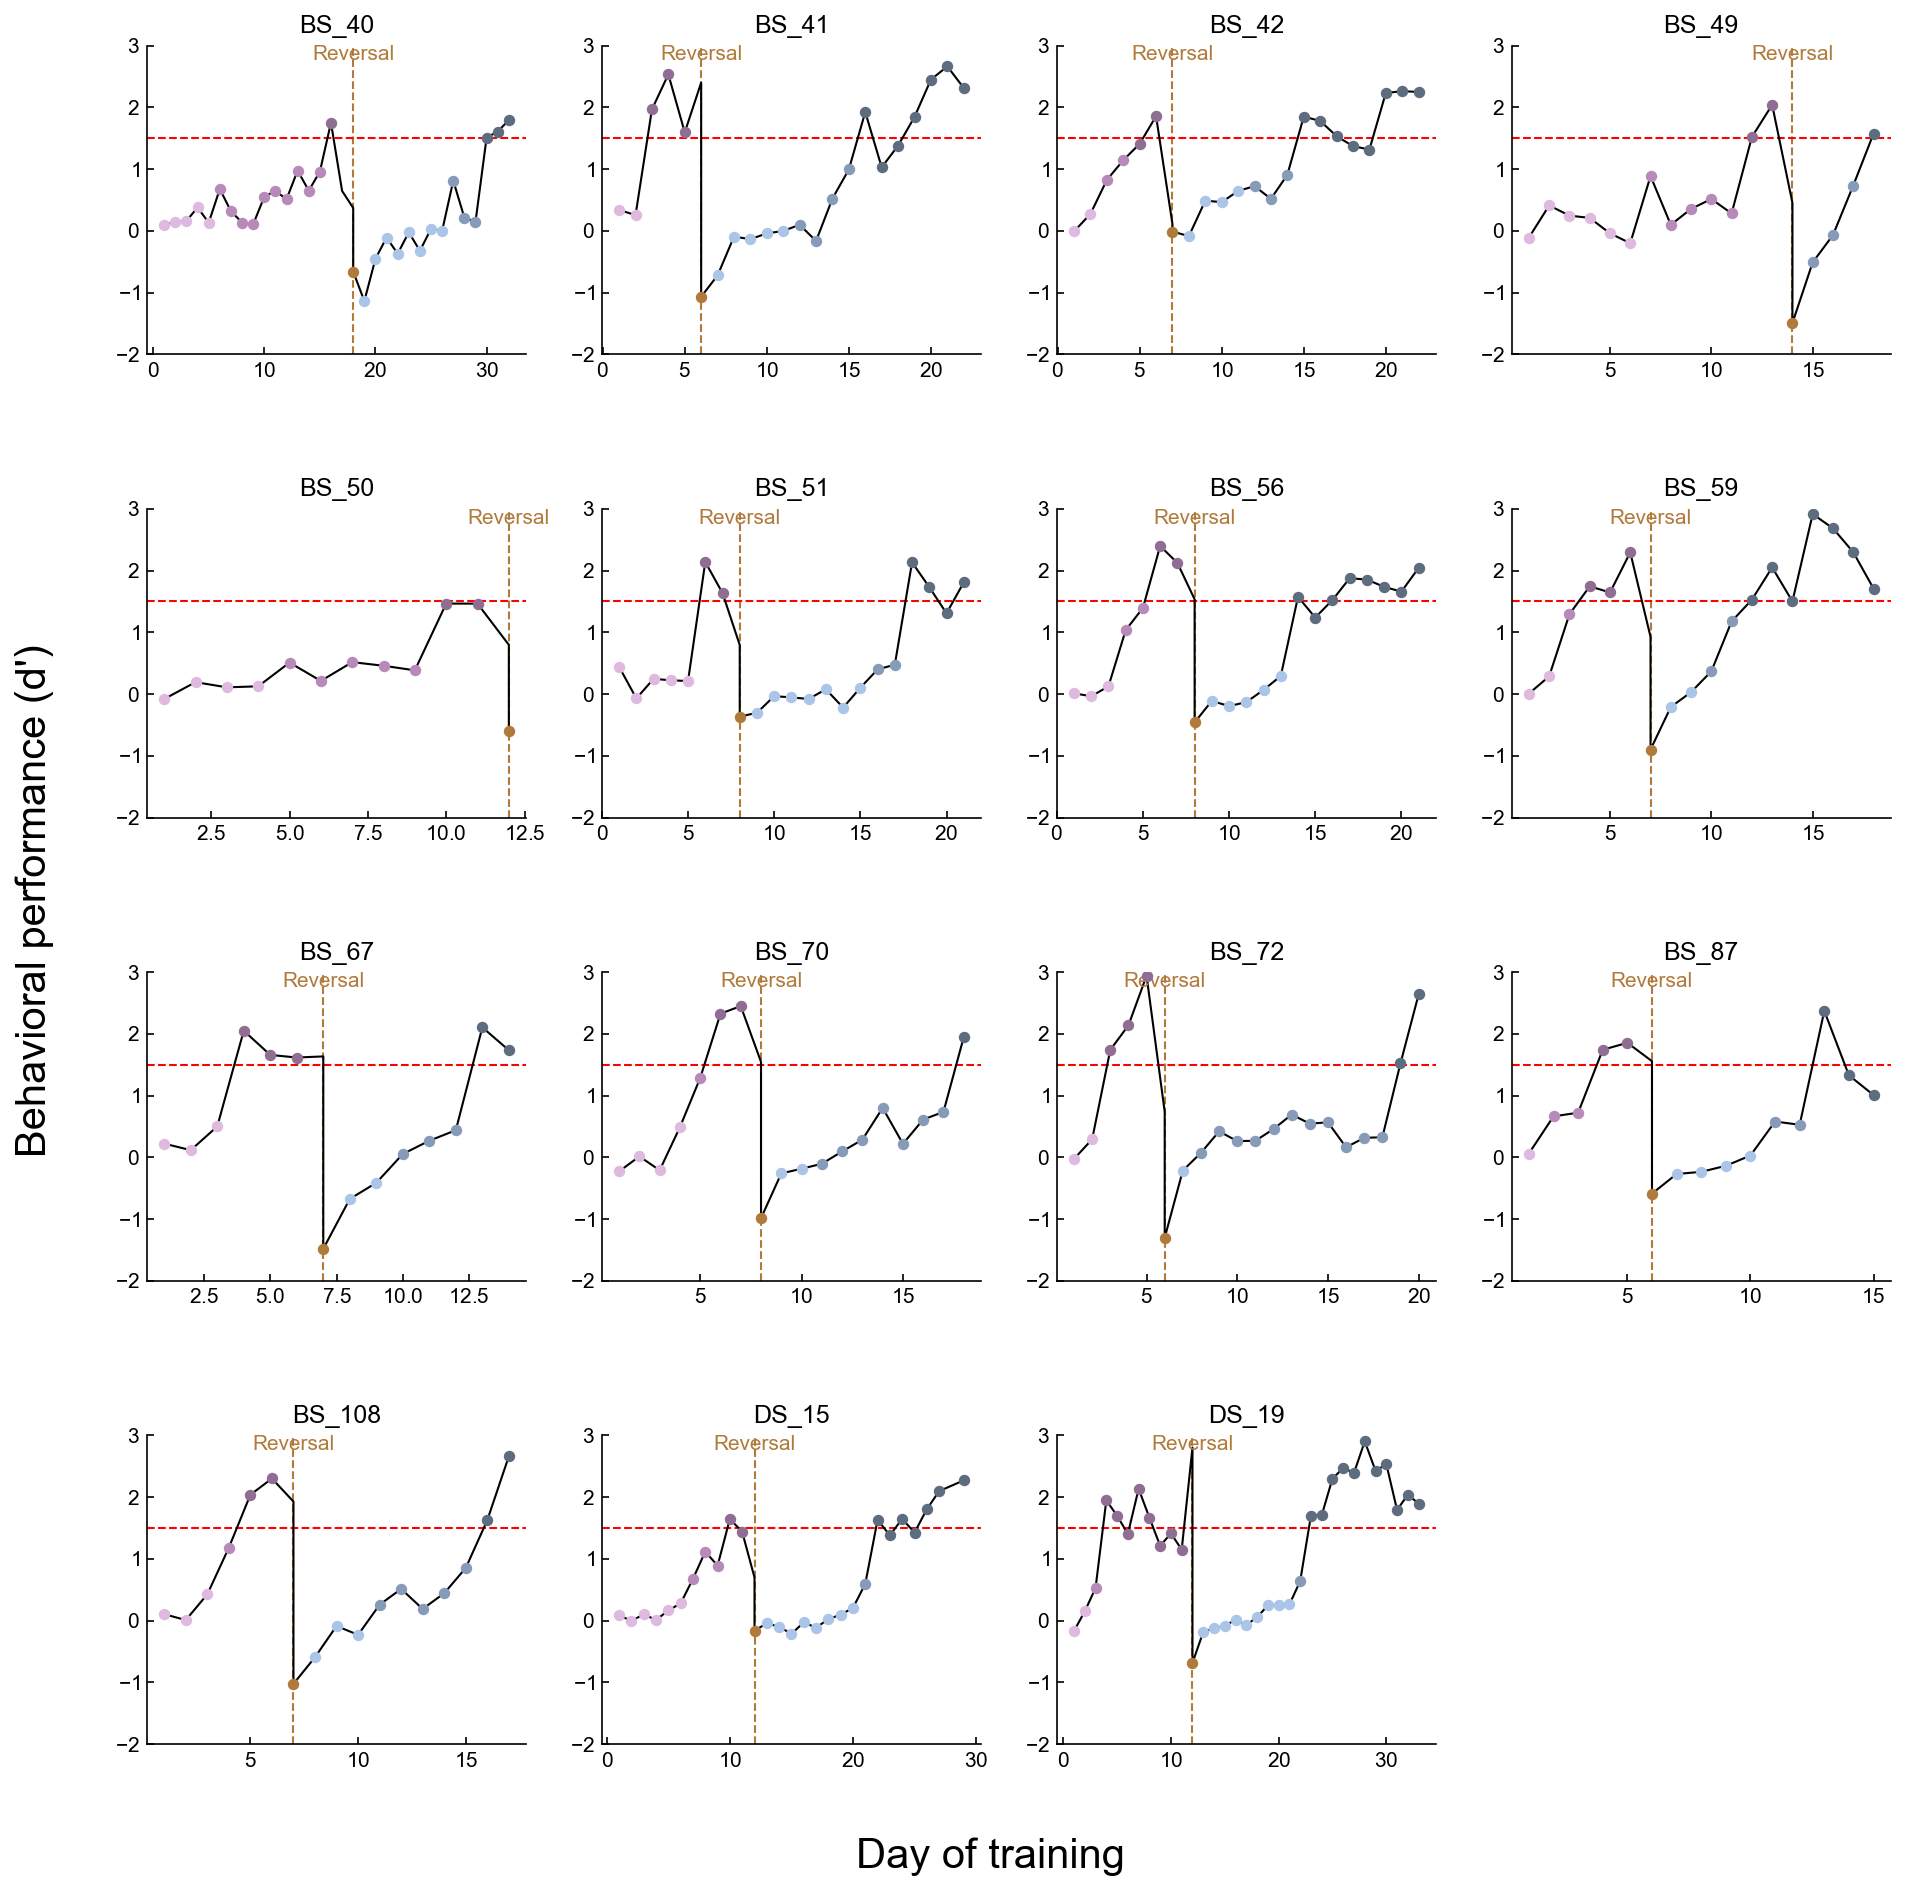

In [23]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(ephys_animals,animalBehaviors,plot=True)

In [14]:
EnumSessionOps = []
EnumClustOps = []
sessions = os.listdir(ops_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.task not in ['opto nonreversal','opto switch','opto reversal']:
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSessionOps.append(session)
        EnumClustOps.append(clust)

100%|██████████| 101/101 [00:00<00:00, 108.46it/s]


In [20]:
EnumSessionControl = []
EnumClustControl = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in ephys_animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSessionControl.append(session)
        EnumClustControl.append(clust)

100%|██████████| 699/699 [00:07<00:00, 91.58it/s] 


In [24]:
EILphases = np.full_like(EnumSessionControl,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSessionControl)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        raise e
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1682/1682 [00:30<00:00, 55.90it/s] 

errors for: []


In [25]:
def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')
    
#getDataPoint(dec_df,'BS_108_1_AC.pickle',9,'stimulus','accuracy')

In [26]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
stim_25s_opsin_on_df = pd.read_csv(stim25sopsinondecodingfilename)
stim_25s_opsin_off_df = pd.read_csv(stim25sopsinoffdecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
choice_opsin_on_df = pd.read_csv(choiceopsinondecodingfilename)
choice_opsin_off_df = pd.read_csv(choiceopsinoffdecodingfilename)
dec_df = pd.concat([stim_25s_df,stim_25s_opsin_on_df,stim_25s_opsin_off_df,choice_df,choice_opsin_on_df,choice_opsin_off_df])

In [27]:
dec_df

,Unnamed: 0,n_rep,categories,session,clust,accuracy,accuracy_std,accuracy_sem,weighted_accuracy,weighted_accuracy_std,...,synthetic_control_weighted_accuracy,synthetic_control_weighted_accuracy_std,synthetic_control_weighted_accuracy_sem,pval_synthetic_control,pval_weighted_synthetic_control,fraction_empty_trials,shuffled_control_accuracy,shuffled_control_accuracy_std,shuffled_control_accuracy_sem,pval_shuffled_control
0,0,500,stimulus,BS_108_1_AC.pickle,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,500,stimulus,BS_108_1_AC.pickle,8,0.723667,0.118274,0.005295,0.721050,0.118908,...,0.495621,0.143328,0.006416,1.489743e-99,4.556428e-96,0.024167,NaN,NaN,NaN,NaN
2,2,500,stimulus,BS_108_1_AC.pickle,9,0.555372,0.139472,0.006244,0.556693,0.139437,...,0.497495,0.138993,0.006222,2.128868e-10,2.725686e-11,0.040372,NaN,NaN,NaN,NaN
3,3,500,stimulus,BS_108_1_AC.pickle,14,0.557372,0.124074,0.005554,0.556641,0.123984,...,0.499797,0.126233,0.005651,5.255247e-12,4.030236e-12,0.239782,NaN,NaN,NaN,NaN
4,4,500,stimulus,BS_108_1_AC.pickle,34,0.634474,0.122586,0.005488,0.640040,0.121779,...,0.502742,0.128044,0.005732,6.755698e-51,7.339776e-56,0.088923,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,1793,500,response_off,BS_92_9_opto_AC.pickle,99,0.713996,0.078963,0.003535,0.567266,0.103253,...,NaN,NaN,NaN,5.033540e-110,NaN,0.733063,0.681510,0.077109,0.003452,7.260218e-09
1794,1794,500,response_off,BS_92_9_opto_AC.pickle,101,0.703443,0.059745,0.002675,0.501448,0.067813,...,NaN,NaN,NaN,4.744495e-117,NaN,0.891340,0.725500,0.050006,0.002250,NaN
1795,1795,500,response_off,BS_92_9_opto_AC.pickle,112,0.716802,0.049807,0.002230,0.493307,0.051982,...,NaN,NaN,NaN,5.536471e-133,NaN,0.877826,0.720308,0.053040,0.002374,3.793669e-01
1796,1796,500,response_off,BS_92_9_opto_AC.pickle,142,0.676779,0.065486,0.002932,0.478814,0.067141,...,NaN,NaN,NaN,2.287565e-104,NaN,0.592723,0.648316,0.087578,0.003921,2.682663e-08


In [29]:
stim_acc_on = []
pval_stim_s_on = []

stim_acc_off = []
pval_stim_s_off = []

stim_acc_control = []
pval_stim_s_control = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSessionOps,EnumClustOps))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus_on','weighted_accuracy')
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus_on','pval_synthetic_control')
    stim_acc_on.append(stim_accuracy)
    pval_stim_s_on.append(pvalue_stim_s)
    

for idx,(session,clust) in tqdm(enumerate(zip(EnumSessionOps,EnumClustOps))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus_off','weighted_accuracy')
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus_off','pval_synthetic_control')
    stim_acc_off.append(stim_accuracy)
    pval_stim_s_off.append(pvalue_stim_s)
    
for idx,(session,clust) in tqdm(enumerate(zip(EnumSessionControl,EnumClustControl))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    stim_acc_control.append(stim_accuracy)
    pval_stim_s_control.append(pvalue_stim_s)
    
stim_acc_control = np.array(stim_acc_control)
pval_stim_s_control = np.array(pval_stim_s_control)
stim_acc_on = np.array(stim_acc_on)
pval_stim_s_on = np.array(pval_stim_s_on)
stim_acc_off = np.array(stim_acc_off)
pval_stim_s_off = np.array(pval_stim_s_off)

999it [00:02, 426.17it/s]
999it [00:02, 434.77it/s]
1682it [00:03, 431.77it/s]


In [78]:
def get_TE_mask(acc,pval_s,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.58#0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]                     #CURRENTLY HARDCODED!!!
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    is_valid_pval = np.less(pval_s,0.05)
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_control,task_encoder_threshold_control = get_TE_mask(stim_acc_control,pval_stim_s_control,pval_stim_c_control)
is_TE_on,task_encoder_threshold_on = get_TE_mask(stim_acc_on,pval_stim_s_on,pval_stim_c_on)
is_TE_off,task_encoder_threshold_off = get_TE_mask(stim_acc_off,pval_stim_s_off,pval_stim_c_off)

Task encoder threshold: 0.58
Task encoder threshold: 0.58
Task encoder threshold: 0.58


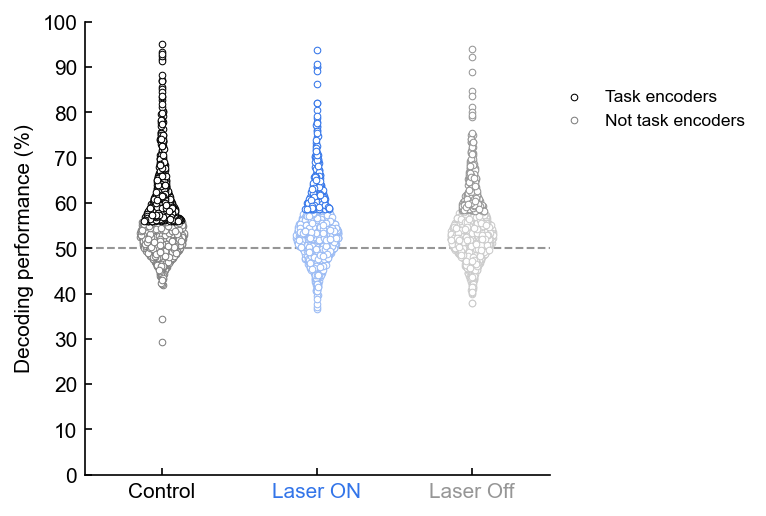

In [34]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig, ax = plt.subplots(figsize=(4,4))

X = np.ones_like(stim_acc_control)
_,Y = ilep.violin(X,stim_acc_control)
X,_ = ilep.violin(X,np.log10(stim_acc_control),width=0.35)
size=10
ax.scatter(X[is_TE_control], Y[is_TE_control], s=size, ec='black', fc='white', lw=0.5,zorder=1)
ax.scatter(X[np.logical_not(is_TE_control)], Y[np.logical_not(is_TE_control)], s=size, ec=lighten_color('black',0.5), fc='white', lw=0.5,zorder=0)

X = np.ones_like(stim_acc_on)+1
_,Y = ilep.violin(X,stim_acc_on)
X,_ = ilep.violin(X,np.log10(stim_acc_on),width=0.35)
ax.scatter(X[is_TE_on], Y[is_TE_on], s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=1)
ax.scatter(X[np.logical_not(is_TE_on)], Y[np.logical_not(is_TE_on)], s=size, ec=lighten_color(LASER_COLOR,0.5), fc='white', lw=0.5,zorder=0)

X = np.ones_like(stim_acc_off)+2
_,Y = ilep.violin(X,stim_acc_off)
X,_ = ilep.violin(X,np.log10(stim_acc_off),width=0.35)
ax.scatter(X[is_TE_off], Y[is_TE_off], s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=1)
ax.scatter(X[np.logical_not(is_TE_off)], Y[np.logical_not(is_TE_off)], s=size, ec=lighten_color(GOOD_GREY,0.5), fc='white', lw=0.5,zorder=0)




ax.set_xlim([0.5,3.5])
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Control','Laser ON','Laser Off'])
colors = ['k',LASER_COLOR,GOOD_GREY]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]

ax.set_ylim([0,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['0','10','20','30','40','50','60','70','80','90','100'])

# ax.axhline(task_encoder_threshold_s,linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
# ax.axhline(0.5,linestyle='--',color='grey',zorder=-10,lw=0.5,xmax=0.5)
# ax.axhline(0.5-(task_encoder_threshold_s-0.5),linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
# #ax.axhline(np.median(stim_acc[is_TE_s]),xmax=0.5,color='green')

ax.set_ylabel('Decoding performance (%)')
#ax.spines['bottom'].set_visible(False)

ax.axhline(0.5,linestyle='--',color=GOOD_GREY,zorder=-10,lw=1)

ax.scatter([],[], s=size, ec='k', fc='white', lw=0.5,zorder=1,label='Task encoders')
ax.scatter([],[], s=size, ec=lighten_color('k',0.5), fc='white', lw=0.5,zorder=1,label='Not task encoders')
lgd = ax.legend(frameon=False,loc=(1,0.75))

#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Task encoders schematic inference buffer.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Task encoders schematic old decoding.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Opsin task encoders schematic.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')
#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Opsin task encoders schematic.png'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Stats -- all cells

In [63]:
np.nanmean(stim_acc_control)

0.5551980202661777

In [64]:
np.nanmean(stim_acc_on)

0.5425601457905667

In [65]:
np.nanmean(stim_acc_off)

0.5436765934588246

In [75]:
context = len(stim_acc_control)*['control'] + len(stim_acc_on)*['ON'] + len(stim_acc_off)*['OFF']
dec = np.concatenate((stim_acc_control,stim_acc_on,stim_acc_off))

df = pd.DataFrame({"context": context, "dec": dec})

### Anova ###
anova = pg.anova(data=df, dv='dec', between=['context'], detailed=True)
print(anova)
print()

### Create and print results ###
pairwise_mwu = pg.pairwise_tests(data=df, dv='dec', between=['context'], padjust="fdr_bh", parametric=False, )
print(pairwise_mwu[pairwise_mwu["Contrast"] == "context"][["A", "B", "p-unc", "p-corr", "hedges"]])
#pairwise_mwu

    Source         SS    DF        MS          F     p-unc       np2
0  context   0.117205     2  0.058603  11.251158  0.000013  0.006732
1   Within  17.292537  3320  0.005209        NaN       NaN       NaN

     A        B     p-unc    p-corr    hedges
0  OFF       ON  0.555370  0.555370  0.015861
1  OFF  control  0.000563  0.000844 -0.159661
2   ON  control  0.000055  0.000164 -0.171402


# Stats -- Task encoders

In [66]:
np.nanmean(stim_acc_control[is_TE_control])

0.6394071318053217

In [67]:
np.nanmean(stim_acc_on[is_TE_on])

0.629849231075697

In [68]:
np.nanmean(stim_acc_off[is_TE_off])

0.6285126931735807

In [79]:
context = len(stim_acc_control[is_TE_control])*['control'] + len(stim_acc_on[is_TE_on])*['ON'] + len(stim_acc_off[is_TE_off])*['OFF']
dec = np.concatenate((stim_acc_control[is_TE_control],stim_acc_on[is_TE_on],stim_acc_off[is_TE_off]))

df = pd.DataFrame({"context": context, "dec": dec})

### Anova ###
anova = pg.anova(data=df, dv='dec', between=['context'], detailed=True)
print(anova)
print()

### Create and print results ###
pairwise_mwu = pg.pairwise_tests(data=df, dv='dec', between=['context'], padjust="fdr_bh", parametric=False, )
print(pairwise_mwu[pairwise_mwu["Contrast"] == "context"][["A", "B", "p-unc", "p-corr", "hedges"]])
#pairwise_mwu

    Source        SS   DF        MS         F     p-unc       np2
0  context  0.017705    2  0.008853  1.827737  0.161458  0.004618
1   Within  3.816713  788  0.004844       NaN       NaN       NaN

     A        B     p-unc    p-corr    hedges
0  OFF       ON  0.878245  0.878245 -0.031634
1  OFF  control  0.353250  0.529875 -0.148734
2   ON  control  0.268393  0.529875 -0.115543


# Stats -- Non task encoders

In [69]:
np.nanmean(stim_acc_control[~is_TE_control])

0.5182149013124956

In [70]:
np.nanmean(stim_acc_on[~is_TE_on])

0.508912397831494

In [71]:
np.nanmean(stim_acc_off[~is_TE_off])

0.5115541867707132

In [80]:
context = len(stim_acc_control[~is_TE_control])*['control'] + len(stim_acc_on[~is_TE_on])*['ON'] + len(stim_acc_off[~is_TE_off])*['OFF']
dec = np.concatenate((stim_acc_control[~is_TE_control],stim_acc_on[~is_TE_on],stim_acc_off[~is_TE_off]))

df = pd.DataFrame({"context": context, "dec": dec})

### Anova ###
anova = pg.anova(data=df, dv='dec', between=['context'], detailed=True)
print(anova)
print()

### Create and print results ###
pairwise_mwu = pg.pairwise_tests(data=df, dv='dec', between=['context'], padjust="fdr_bh", parametric=False, )
print(pairwise_mwu[pairwise_mwu["Contrast"] == "context"][["A", "B", "p-unc", "p-corr", "hedges"]])
#pairwise_mwu

    Source        SS    DF        MS          F     p-unc       np2
0  context  0.034182     2  0.017091  12.006859  0.000006  0.009406
1   Within  3.599901  2529  0.001423        NaN       NaN       NaN

     A        B     p-unc    p-corr    hedges
0  OFF       ON  0.327577  0.327577  0.062360
1  OFF  control  0.004192  0.006288 -0.164999
2   ON  control  0.000104  0.000311 -0.226163


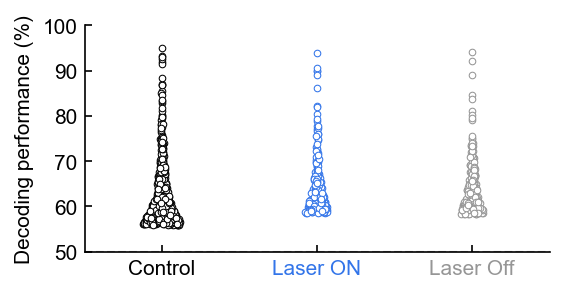

In [59]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig, ax = plt.subplots(figsize=(4,2))

X = np.ones_like(stim_acc_control)
_,Y = ilep.violin(X,stim_acc_control)
X,_ = ilep.violin(X,np.log10(stim_acc_control),width=0.35)
size=10
ax.scatter(X[is_TE_control], Y[is_TE_control], s=size, ec='black', fc='white', lw=0.5,zorder=1)
#ax.scatter(X[np.logical_not(is_TE_control)], Y[np.logical_not(is_TE_control)], s=size, ec=lighten_color('black',0.5), fc='white', lw=0.5,zorder=0)

X = np.ones_like(stim_acc_on)+1
_,Y = ilep.violin(X,stim_acc_on)
X,_ = ilep.violin(X,np.log10(stim_acc_on),width=0.35)
ax.scatter(X[is_TE_on], Y[is_TE_on], s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=1)
#ax.scatter(X[np.logical_not(is_TE_on)], Y[np.logical_not(is_TE_on)], s=size, ec=lighten_color(LASER_COLOR,0.5), fc='white', lw=0.5,zorder=0)

X = np.ones_like(stim_acc_off)+2
_,Y = ilep.violin(X,stim_acc_off)
X,_ = ilep.violin(X,np.log10(stim_acc_off),width=0.35)
ax.scatter(X[is_TE_off], Y[is_TE_off], s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=1)
#ax.scatter(X[np.logical_not(is_TE_off)], Y[np.logical_not(is_TE_off)], s=size, ec=lighten_color(GOOD_GREY,0.5), fc='white', lw=0.5,zorder=0)




ax.set_xlim([0.5,3.5])
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Control','Laser ON','Laser Off'])
colors = ['k',LASER_COLOR,GOOD_GREY]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]

ax.set_ylim([0.5,1])
ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['50','60','70','80','90','100'])

# ax.axhline(task_encoder_threshold_s,linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
# ax.axhline(0.5,linestyle='--',color='grey',zorder=-10,lw=0.5,xmax=0.5)
# ax.axhline(0.5-(task_encoder_threshold_s-0.5),linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
# #ax.axhline(np.median(stim_acc[is_TE_s]),xmax=0.5,color='green')

ax.set_ylabel('Decoding performance (%)')
#ax.spines['bottom'].set_visible(False)

ax.axhline(0.5,linestyle='--',color=GOOD_GREY,zorder=-10,lw=1)

#ax.scatter([],[], s=size, ec='k', fc='white', lw=0.5,zorder=1,label='Task encoders')
#ax.scatter([],[], s=size, ec=lighten_color('k',0.5), fc='white', lw=0.5,zorder=1,label='Not task encoders')
#lgd = ax.legend(frameon=False,loc=(1,0.75))

#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Task encoders schematic inference buffer.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Task encoders schematic old decoding.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Opsin task encoders schematic TE only.pdf'),transparent=False,facecolor="white")#, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Opsin task encoders schematic TE only.png'),transparent=False,facecolor="white")#, bbox_extra_artists=(lgd,), bbox_inches='tight')

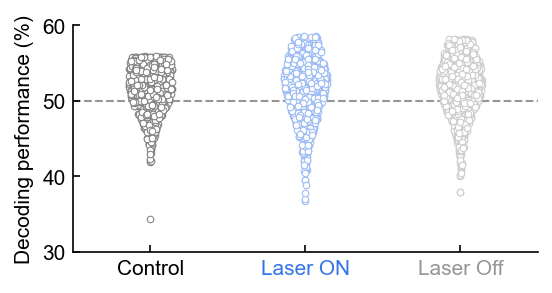

In [61]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig, ax = plt.subplots(figsize=(4,2))

X = np.ones_like(stim_acc_control)
_,Y = ilep.violin(X,stim_acc_control)
X,_ = ilep.violin(X,np.log10(stim_acc_control),width=0.35)
size=10
#ax.scatter(X[is_TE_control], Y[is_TE_control], s=size, ec='black', fc='white', lw=0.5,zorder=1)
ax.scatter(X[np.logical_not(is_TE_control)], Y[np.logical_not(is_TE_control)], s=size, ec=lighten_color('black',0.5), fc='white', lw=0.5,zorder=0)

X = np.ones_like(stim_acc_on)+1
_,Y = ilep.violin(X,stim_acc_on)
X,_ = ilep.violin(X,np.log10(stim_acc_on),width=0.35)
#ax.scatter(X[is_TE_on], Y[is_TE_on], s=size, ec=LASER_COLOR, fc='white', lw=0.5,zorder=1)
ax.scatter(X[np.logical_not(is_TE_on)], Y[np.logical_not(is_TE_on)], s=size, ec=lighten_color(LASER_COLOR,0.5), fc='white', lw=0.5,zorder=0)

X = np.ones_like(stim_acc_off)+2
_,Y = ilep.violin(X,stim_acc_off)
X,_ = ilep.violin(X,np.log10(stim_acc_off),width=0.35)
#ax.scatter(X[is_TE_off], Y[is_TE_off], s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=1)
ax.scatter(X[np.logical_not(is_TE_off)], Y[np.logical_not(is_TE_off)], s=size, ec=lighten_color(GOOD_GREY,0.5), fc='white', lw=0.5,zorder=0)




ax.set_xlim([0.5,3.5])
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Control','Laser ON','Laser Off'])
colors = ['k',LASER_COLOR,GOOD_GREY]
[t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]

ax.set_ylim([0.3,0.6])
ax.set_yticks([0.3,0.4,0.5,0.6])
ax.set_yticklabels(['30','40','50','60'])

# ax.axhline(task_encoder_threshold_s,linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
# ax.axhline(0.5,linestyle='--',color='grey',zorder=-10,lw=0.5,xmax=0.5)
# ax.axhline(0.5-(task_encoder_threshold_s-0.5),linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
# #ax.axhline(np.median(stim_acc[is_TE_s]),xmax=0.5,color='green')

ax.set_ylabel('Decoding performance (%)')
#ax.spines['bottom'].set_visible(False)

ax.axhline(0.5,linestyle='--',color=GOOD_GREY,zorder=-10,lw=1)

#ax.scatter([],[], s=size, ec='k', fc='white', lw=0.5,zorder=1,label='Task encoders')
#ax.scatter([],[], s=size, ec=lighten_color('k',0.5), fc='white', lw=0.5,zorder=1,label='Not task encoders')
#lgd = ax.legend(frameon=False,loc=(1,0.75))

#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Task encoders schematic inference buffer.pdf'),transparent=False,facecolor="white")
#plt.savefig(os.path.join('D:\\\\TempFigures','Decoding Comparisons','Task encoders schematic old decoding.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Opsin task encoders schematic nonTE only.pdf'),transparent=False,facecolor="white")#, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Opsin task encoders schematic nonTE only.png'),transparent=False,facecolor="white")#, bbox_extra_artists=(lgd,), bbox_inches='tight')